In [1]:
import os
import timeit
import numpy as np
import pandas as pd

import shapely
import geopandas as gpd
import xarray as xr
import rioxarray
from geocube.api.core import make_geocube

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


### Create the land and ocean mask files
As an alternative to using state- and county-level boundaries for our raster burn method, we can also create a grid at the native-level resolution of the dataset we are interested in. One important limitation of this approach, though, is that if you wanted to combine and show multiple datasets on a web map, they would all need to be at (or reprojected to) the same resolution. With the GADM-shapefile approach, you can "burn" rasters into a standardized geometry, meaning that data can come from different resolutions.

All of these boundaries for this approach came from [Natural Earth](https://www.naturalearthdata.com/downloads/).

In [3]:
# this dataset is limited to the us, would need to use gadm version
ne_admin_path = '../../data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
ne_admin = gpd.read_file(ne_admin_path)


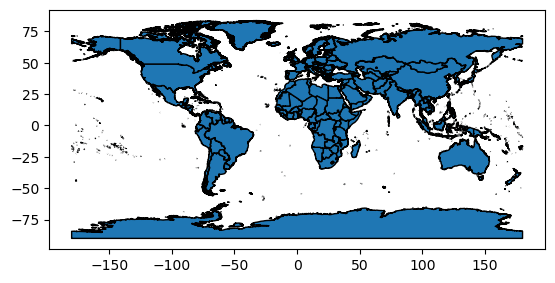

In [4]:
ne_admin.plot(edgecolor='black')
plt.show()


In [4]:
ne_admin.to_file('../../data/countries.gpkg', driver='GPKG', layer='ne_admin_level_0') 
with open("../../data/countries.json", "w") as file:
  file.write(ne_admin.to_json())


In [5]:
ne_land_path = '../../data/ne_10m_land/ne_10m_land.shp'
ne_land = gpd.read_file(ne_land_path)

ne_ocean_path = '../../data/ne_10m_ocean/ne_10m_ocean.shp'
ne_ocean = gpd.read_file(ne_ocean_path)

ne_lakes_path = '../../data/ne_110m_lakes/ne_110m_lakes.shp'
ne_lakes = gpd.read_file(ne_lakes_path)


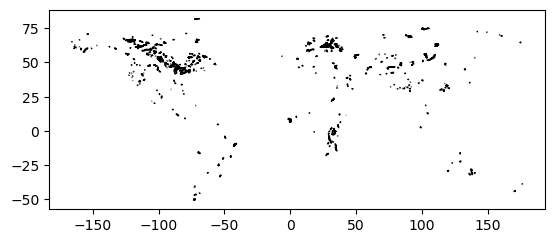

In [6]:
ne_lakes_path = '../../data/ne_50m_lakes/ne_50m_lakes.shp'
ne_lakes = gpd.read_file(ne_lakes_path)

ne_lakes.plot(edgecolor='black')
plt.show()


In [7]:
ne_lakes.to_file('../../data/lakes_50m.gpkg', driver='GPKG', layer='lakes_50m') 
with open("../../data/lakes_50m.json", "w") as file:
  file.write(ne_lakes.to_json())


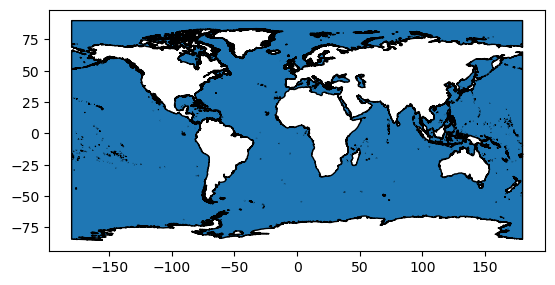

In [8]:
ne_ocean.plot(edgecolor='black')
plt.show()


In [9]:
ne_land.to_file('../../data/land_mask.gpkg', driver='GPKG', layer='land_mask') 
with open("../../data/land_mask.json", "w") as file:
  file.write(ne_land.to_json())


In [10]:
ne_ocean.to_file('../../data/ocean_mask.gpkg', driver='GPKG', layer='ocean_mask') 
with open("../../data/ocean_mask.json", "w") as file:
  file.write(ne_ocean.to_json())


In [ ]:
# if i wanted to create a land mask that did not include lakes, i could do that here
# res_symdiff = lakes.overlay(land_mask_ne_land, how='symmetric_difference')
# res_symdiff.plot(edgecolor='black')
# plt.show()


## Load in raster data
For demonstration purposes, I am using [WorldClim](https://worldclim.org/data/worldclim21.html) historical climate data.

In [32]:
raster_path = "../../data/wc2.1_10m_tavg_01.tif"
var = "tavg"
ds = xr.open_dataset(raster_path, default_name=var).drop('band')
ds


<xarray.Dataset>
Dimensions:      (x: 2160, y: 1080, band: 1)
Coordinates:
  * x            (x) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
  * y            (y) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
    spatial_ref  int64 ...
Dimensions without coordinates: band
Data variables:
    tavg         (band, y, x) float32 ...

In [37]:
ds.rio.crs


CRS.from_epsg(4326)

In [41]:
num_cells = ds[var].shape[0] * ds[var].shape[1]
print(f"Total number of cells:               {num_cells}")

num_nan_cells = np.sum(np.isnan(ds[var].data))
print(f"Total number of cells without value: {num_nan_cells}")


Total number of cells:               1080
Total number of cells without value: 1524747


In [43]:
min_value = ds.min(skipna=True)[var].data
max_value = ds.max(skipna=True)[var].data
print(min_value, max_value)


-45.884 34.0095


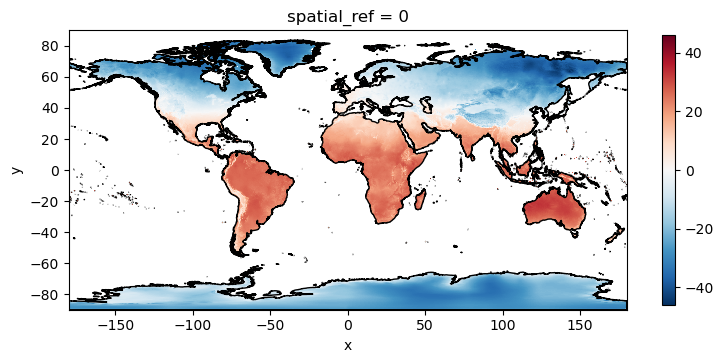

In [46]:
fig, ax = plt.subplots(figsize=(9, 7))
image = ds[var].plot(cmap="RdBu_r", add_colorbar=False, ax=ax)
ne_land.plot(facecolor='None', edgecolor='black', ax=ax)
plt.colorbar(image, shrink=0.5)
plt.show()


## Creating the overlay grid

### World grid
Next, we can create grid cells for every point in the input raster.

In [47]:
num_x, num_y = ds.x.size, ds.y.size
print(num_x, num_y)


2160 1080


In [48]:
xmin, xmax = ds.x[0].values, ds.x[-1].values
ymin, ymax = ds.y[0].values, ds.y[-1].values

x_diff = ds.x[1].values - ds.x[0].values
y_diff = ds.y[1].values - ds.y[0].values
print(x_diff, y_diff)

print(xmin, xmax)
print(ymin, ymax)


0.1666666666666572 -0.1666666666666714
-179.91666666666666 179.91666666666666
89.91666666666667 -89.91666666666664


In [49]:
grid_cells = []

for x in ds.x.values - (x_diff / 2):
    for y in ds.y.values - (y_diff / 2):
        grid_cells.append(shapely.Polygon([(x, y), (x + x_diff, y), (x + x_diff, y + y_diff), (x, y + y_diff)]))


In [50]:
grid_cells[:5]


[<POLYGON ((-180 90, -179.833 90, -179.833 89.833, -180 89.833, -180 90))>,
 <POLYGON ((-180 89.833, -179.833 89.833, -179.833 89.667, -180 89.667, -180 ...>,
 <POLYGON ((-180 89.667, -179.833 89.667, -179.833 89.5, -180 89.5, -180 89.6...>,
 <POLYGON ((-180 89.5, -179.833 89.5, -179.833 89.333, -180 89.333, -180 89.5))>,
 <POLYGON ((-180 89.333, -179.833 89.333, -179.833 89.167, -180 89.167, -180 ...>]

In [51]:
grid = gpd.GeoDataFrame(geometry=[*grid_cells], crs=ne_land.crs)
grid


,geometry
0,"POLYGON ((-180.00000 90.00000, -179.83333 90.0..."
1,"POLYGON ((-180.00000 89.83333, -179.83333 89.8..."
2,"POLYGON ((-180.00000 89.66667, -179.83333 89.6..."
3,"POLYGON ((-180.00000 89.50000, -179.83333 89.5..."
4,"POLYGON ((-180.00000 89.33333, -179.83333 89.3..."
...,...
2332795,"POLYGON ((179.83333 -89.16667, 180.00000 -89.1..."
2332796,"POLYGON ((179.83333 -89.33333, 180.00000 -89.3..."
2332797,"POLYGON ((179.83333 -89.50000, 180.00000 -89.5..."
2332798,"POLYGON ((179.83333 -89.66667, 180.00000 -89.6..."


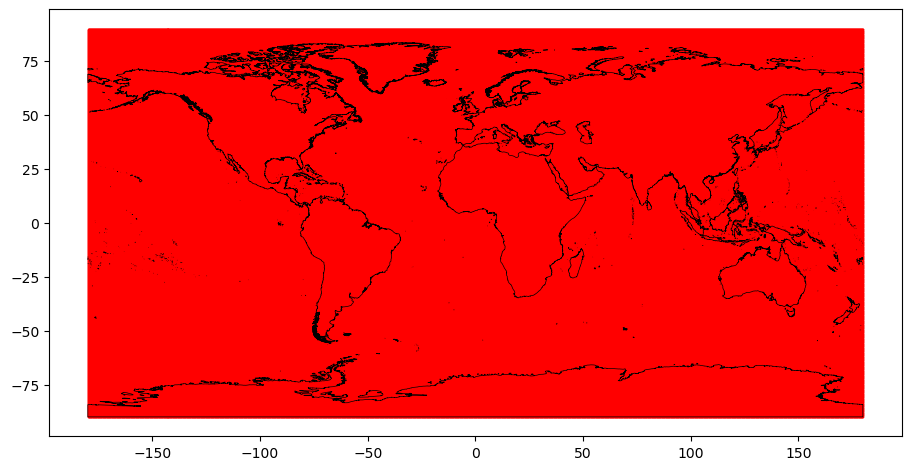

In [52]:
fig, ax = plt.subplots(figsize=(11, 7))
grid.plot(facecolor='none', edgecolor='red', ax=ax)
ne_land.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)
plt.show()


Right now, the grid covers the entire globe, because the input data file has data everywhere (even if it is NaN). This grid will serve as the basis for the land and ocean grids below.

### Land grid

Let's clip the grid to cover just land below. **Note**: this takes a while to run.

In [53]:
land_grid = gpd.sjoin(grid, ne_land, how='inner').drop_duplicates('geometry')
land_grid.drop('index_right', axis=1, inplace=True)
land_grid.drop(['featurecla', 'scalerank', 'min_zoom'], axis=1, inplace=True)
land_grid.head()


,geometry
110,"POLYGON ((-180.00000 71.66667, -179.83333 71.6..."
111,"POLYGON ((-180.00000 71.50000, -179.83333 71.5..."
112,"POLYGON ((-180.00000 71.33333, -179.83333 71.3..."
113,"POLYGON ((-180.00000 71.16667, -179.83333 71.1..."
114,"POLYGON ((-180.00000 71.00000, -179.83333 71.0..."


In [54]:
land_grid = land_grid_short


array([    110,     111,     112, ..., 1165860, 1166939, 1166940])

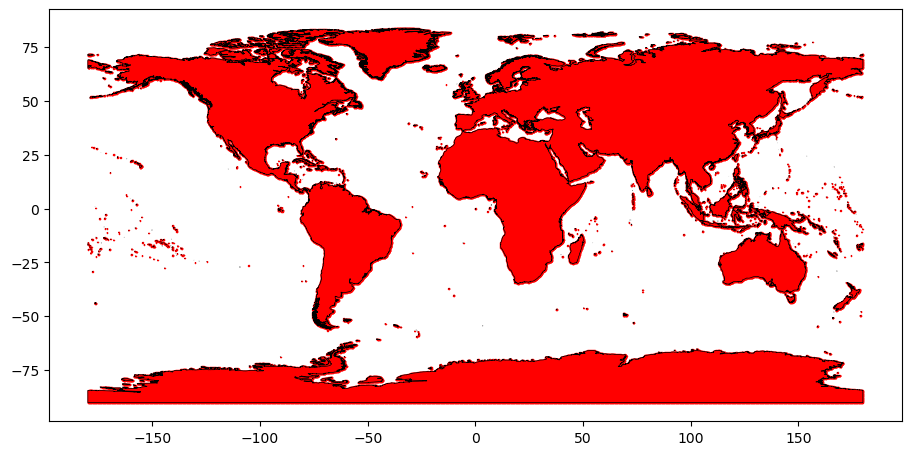

In [55]:
fig, ax = plt.subplots(figsize=(11, 7))
land_grid.plot(facecolor='none', edgecolor='red', ax=ax)
ne_land.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)
plt.show()


### Ocean grid

We could create an ocean grid that is essentially a "not-land" mask with the following code:
```python
ocean_grid = grid.drop(land_grid.index.values)
```
But for datasets like sea level rise, we actually want the data to minimally overlap with the land so that it goes up to the land boundaries. Then we can mask the overlap with the land mask. We can create this ocean mask below.

In [56]:
ocean_grid = gpd.sjoin(grid, ne_ocean, how='inner').drop_duplicates('geometry')
ocean_grid.drop(['index_right', 'featurecla', 'scalerank', 'min_zoom'], axis=1, inplace=True)
ocean_grid.head()


,geometry
0,"POLYGON ((-180.00000 90.00000, -179.83333 90.0..."
1,"POLYGON ((-180.00000 89.83333, -179.83333 89.8..."
2,"POLYGON ((-180.00000 89.66667, -179.83333 89.6..."
3,"POLYGON ((-180.00000 89.50000, -179.83333 89.5..."
4,"POLYGON ((-180.00000 89.33333, -179.83333 89.3..."


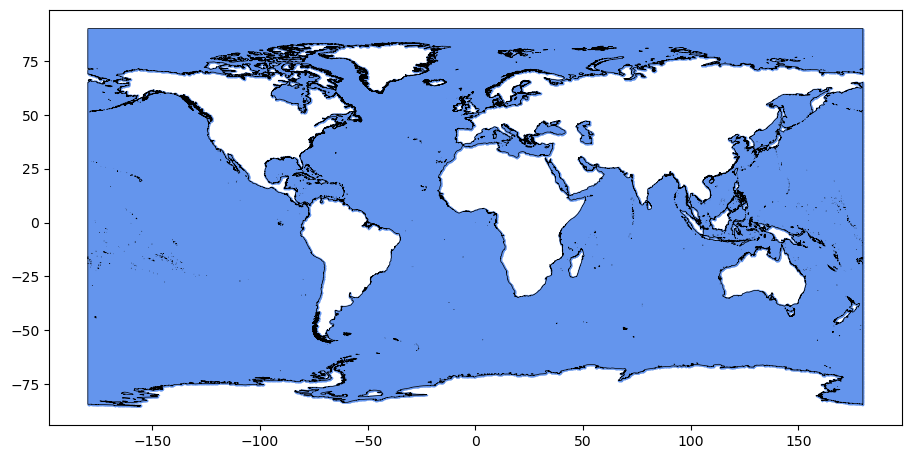

In [57]:
fig, ax = plt.subplots(figsize=(11, 7))
ocean_grid.plot(facecolor='none', edgecolor='cornflowerblue', ax=ax)
ne_ocean.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)
plt.show()


In [60]:
# save land grid data
# land_grid.to_file('../../data/land_grid.gpkg', driver='GPKG', layer='land_grid') 
# with open("../data/land_grid.json", "w") as file:
#   file.write(land_grid.to_json())

# save ocean grid data
# ocean_grid.to_file('../../data/ocean_grid.gpkg', driver='GPKG', layer='ocean_grid') 
# with open("../data/ocean_grid.json", "w") as file:
#   file.write(ocean_grid.to_json())


## Inspecting the grids

In [2]:
land_grid = gpd.read_file('../../data/land_grid.gpkg')
ocean_grid = gpd.read_file('../../data/ocean_grid.gpkg')

ne_land_path = '../../data/ne_10m_land/ne_10m_land.shp'
ne_land = gpd.read_file(ne_land_path)

raster_path = "../../data/wc2.1_10m_tavg_01.tif"
var = "tavg"
ds = xr.open_dataset(raster_path, default_name=var).drop('band')


### Cape Verde

In [3]:
# bounding box of cape_verde: [-25.36180305,  14.801805  , -22.656805  ,  17.20541573]
plot_raster = ds.sel(x=slice(-26, -22), y=slice(18, 14))
plot_raster


<xarray.Dataset>
Dimensions:      (x: 24, y: 24, band: 1)
Coordinates:
  * x            (x) float64 -25.92 -25.75 -25.58 ... -22.42 -22.25 -22.08
  * y            (y) float64 17.92 17.75 17.58 17.42 ... 14.58 14.42 14.25 14.08
    spatial_ref  int64 ...
Dimensions without coordinates: band
Data variables:
    tavg         (band, y, x) float32 ...

In [4]:
plot_points = []
for xpoint in list(plot_raster.x.values):
    line_points = [[xpoint, ypoint] for ypoint in list(plot_raster.y.values)]
    plot_points.append(line_points)

plot_points_flat = [point for sublist in plot_points for point in sublist]
plot_points_flat[:5]


[[-25.916666666666657, 17.91666666666667],
 [-25.916666666666657, 17.750000000000014],
 [-25.916666666666657, 17.583333333333343],
 [-25.916666666666657, 17.41666666666667],
 [-25.916666666666657, 17.250000000000014]]

In [5]:
np.array(plot_points_flat)[:, 0][:5]

array([-25.91666667, -25.91666667, -25.91666667, -25.91666667,
       -25.91666667])

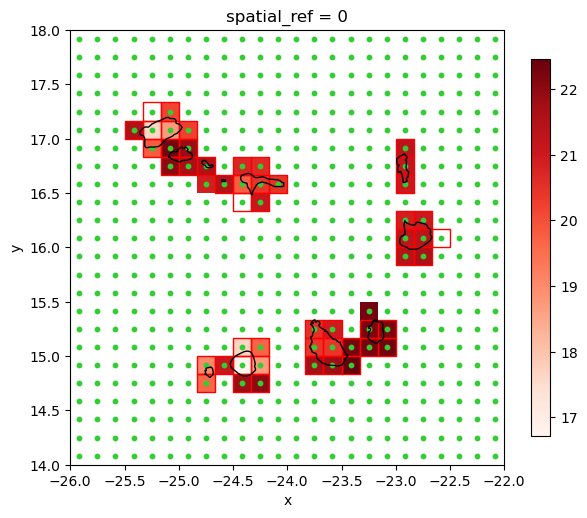

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax)
ax.scatter(np.array(plot_points_flat)[:, 0], np.array(plot_points_flat)[:, 1], s=10, color='limegreen')

land_grid.plot(facecolor='none', edgecolor='red', ax=ax)
ne_land.plot(facecolor='none', edgecolor='black', ax=ax)
plt.colorbar(img, shrink=0.7, ax=ax)

plt.show()


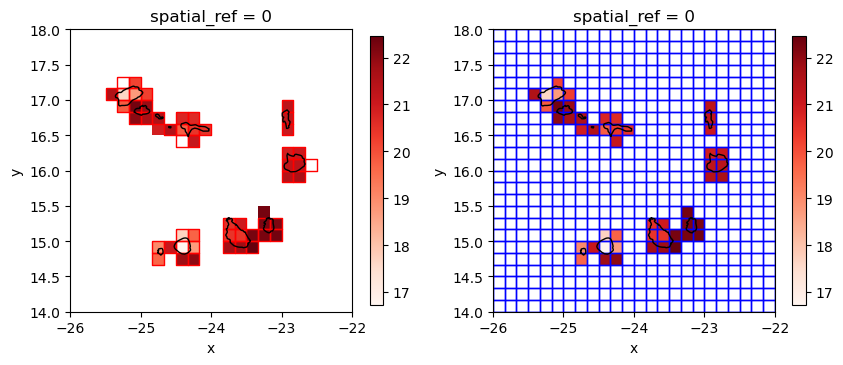

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax[0])
land_grid.plot(facecolor='none', edgecolor='red', ax=ax[0])
ne_land.plot(facecolor='none', edgecolor='black', ax=ax[0])
plt.colorbar(img, shrink=0.5, ax=ax[0])

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax[1])
ocean_grid.plot(facecolor='none', edgecolor='blue', ax=ax[1])
ne_land.plot(facecolor='none', edgecolor='black', ax=ax[1])
plt.colorbar(img, shrink=0.5, ax=ax[1])

plt.show()


It may look like the ocean grid is covering the full chain of islands, but that is just because the polygons are small. A few more examples will show that this is not a problem.

### Cuba

In [8]:
# bounding box of cuba: [-84.951248  ,  19.825972  , -74.13118744,  23.276527  ]
plot_raster = ds.sel(x=slice(-85, -74), y=slice(24, 19))


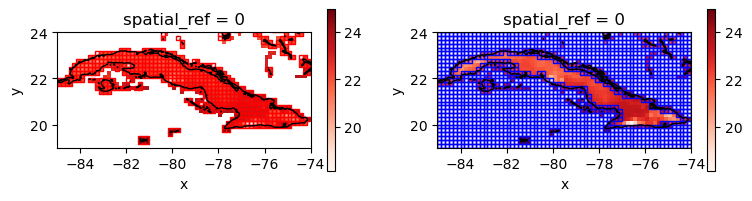

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9, 7))

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax[0])
land_grid.plot(facecolor='none', edgecolor='red', ax=ax[0])
ne_land.plot(facecolor='none', edgecolor='black', ax=ax[0])
plt.colorbar(img, shrink=0.3, ax=ax[0])

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax[1])
ocean_grid.plot(facecolor='none', edgecolor='blue', ax=ax[1])
ne_land.plot(facecolor='none', edgecolor='black', ax=ax[1])
plt.colorbar(img, shrink=0.3, ax=ax[1])

plt.show()


Here, we can see that sometimes the input dataset has data values at some points where our land grid doesn't have polygons. That is okay. The larger point is that all of our polygons in the grid have data values.

### Mexico

In [10]:
# bounding box of mexico: [-118.36648469,   14.53507424,  -86.7107429 ,   32.71862601]
plot_raster = ds.sel(x=slice(-118, -87), y=slice(33, 14))


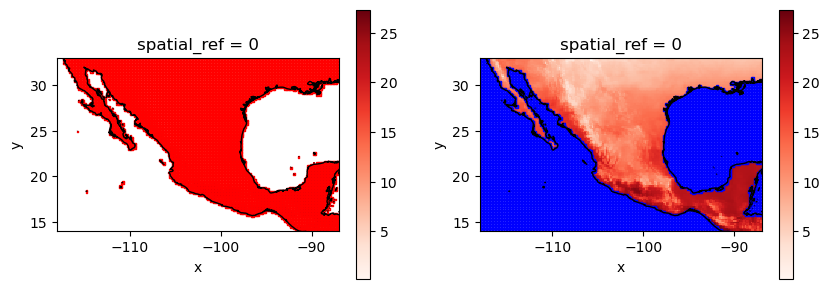

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax[0])
land_grid.plot(facecolor='none', edgecolor='red', ax=ax[0])
ne_land.plot(facecolor='none', edgecolor='black', ax=ax[0])
plt.colorbar(img, shrink=0.5, ax=ax[0])

img = plot_raster[var].plot(cmap="Reds", add_colorbar=False, ax=ax[1])
ocean_grid.plot(facecolor='none', edgecolor='blue', ax=ax[1])
ne_land.plot(facecolor='none', edgecolor='black', ax=ax[1])
plt.colorbar(img, shrink=0.5, ax=ax[1])

plt.show()
